### Kuramoto Sivashinsky (regular) equation in JAX

$\begin{aligned}
    &u_t + \alpha uu_x + \beta u_{xx} + \gamma u_{xxxx} = 0 \\
    &\alpha = 5, \beta = 0.5, \gamma = 0.005 \\
    &u_0(x) = -\sin (\pi x) 
\end{aligned}$

### Acknowledgments

The following sections contain code that is based on the original work by Mahmoud Asem. 

The original code can be found at https://github.com/ASEM000/Physics-informed-neural-network-in-JAX/tree/main. 

We have made some modifications to the original code to suit the needs of our study and to allow for a fair comparison with our method.

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import scipy
from tqdm import trange

In [2]:
N_0 = 100
N_b = 100
N_r = 10_000

tmin,tmax=0. ,1.
xmin,xmax = -1.,1.

'''boundary conditions'''


# U[0,x] = -sin(pi*x)
t_0 = jnp.ones([N_0,1],dtype='float32')*0.
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
ic_0 = -jnp.sin(jnp.pi*x_0)
IC_0 = jnp.concatenate([t_0,x_0,ic_0],axis=1)

# U[t,-1] = 0
t_b1 = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b1 = jnp.ones_like(t_b1) *-1
bc_1 = jnp.zeros_like(t_b1)
BC_1 = jnp.concatenate([t_b1,x_b1,bc_1],axis=1)

# U[t,1] = 0
t_b2 = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b2 = jnp.ones_like(t_b2) 
bc_2 = jnp.zeros_like(t_b2)
BC_2 = jnp.concatenate([t_b2,x_b2,bc_2],axis=1)

conds = [IC_0,BC_1,BC_2]

#collocation points
t_c = np.random.uniform(low=tmin,high=tmax,size=(N_r,1))
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_r,1))
colloc = jnp.concatenate([t_c,x_c],axis=1) 

def PDE_loss(t,x,u):
  u_x=lambda t,x:jax.grad(lambda t,x:jnp.sum(u(t,x)),1)(t,x)
  u_xx=lambda t,x:jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)(t,x)
  u_xxx=lambda t,x:jax.grad(lambda t,x : jnp.sum(u_xx(t,x)),1)(t,x)
  u_xxxx=lambda t,x:jax.grad(lambda t,x : jnp.sum(u_xxx(t,x)),1)(t,x)
  u_t=lambda t,x:jax.grad(lambda t,x:jnp.sum(u(t,x)),0)(t,x)
  return u_t(t,x) + 5*u(t,x)*u_x(t,x) + 0.5*u_xx(t,x) + 0.005*u_xxxx(t,x)

/tmp/ipykernel_14703/636771786.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t_c, x_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
/tmp/ipykernel_14703/636771786.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


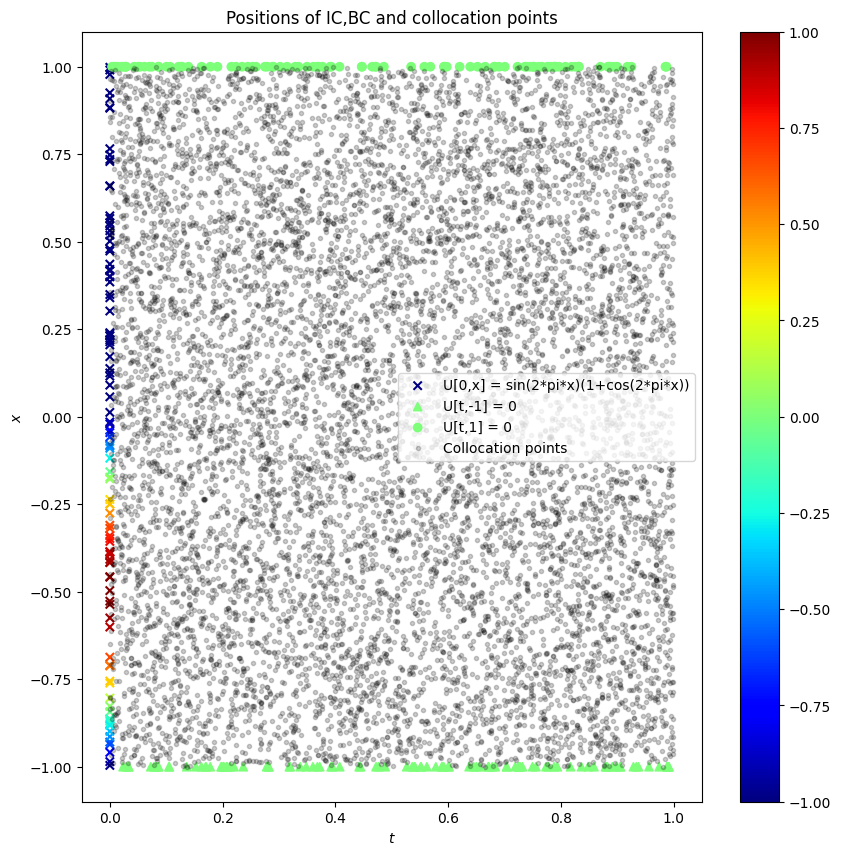

In [3]:
fig = plt.figure(figsize=(10,10))
plt.scatter(t_0, x_0, c=ic_0, marker='x', vmin=0, vmax=1,label='U[0,x] = sin(2*pi*x)(1+cos(2*pi*x))',cmap=cm.jet)
plt.scatter(t_b1, x_b1, c=bc_1, marker='^', vmin=-1, vmax=1,label='U[t,-1] = 0',cmap=cm.jet)
plt.scatter(t_b2, x_b2, c=bc_2, marker='o', vmin=-1, vmax=1,label='U[t,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-1, vmax=1)


plt.scatter(t_c, x_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of IC,BC and collocation points');
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')

In [4]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,conds):
  t_c,x_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda t,x : fwd(params,t,x)
  loss =jnp.mean(PDE_loss(t_c,x_c,ufunc) **2)

  for cond in conds :
    t_b,x_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
    loss += MSE(u_b,ufunc(t_b,x_b))
  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)
  
  #Update paramspbar.set_postfix_str
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  #Update params
  # return jax.tree_multimap(lambda params,grads : params-LR*grads, params,grads)
  return opt_state,params

In [5]:
# construct the MLP of  3 hidden layers of 128 neurons for each layer
params = init_params([2] + [128]*4 + [1])

In [6]:
lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [7]:
%%time
epochs = 20_000
pbar = trange(0, epochs, ncols=150)
for _ in pbar:
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    pbar.set_postfix_str(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

100%|███████████████████████████████████████████████████████████████████████████████| 20000/20000 [28:04<00:00, 11.87it/s, Epoch=19900	loss=3.874e-01]

CPU times: user 16min 14s, sys: 11min 11s, total: 27min 26s
Wall time: 28min 4s


In [8]:
def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(xmin, xmax)
    ax.view_init(35,35)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')

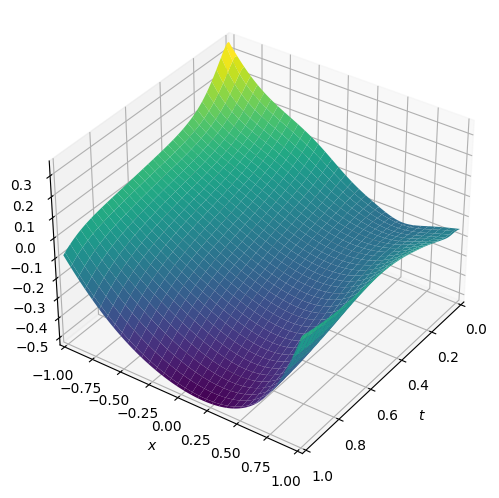

In [9]:
N = 100
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X = np.meshgrid(tspace, xspace)

# Determine predictions of u(t, x)
upred = fwd(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1))

# Reshape upred
U = upred.reshape(N+1,N+1)
plot2D(T,X,U)

L2 error: 1.00749e+00


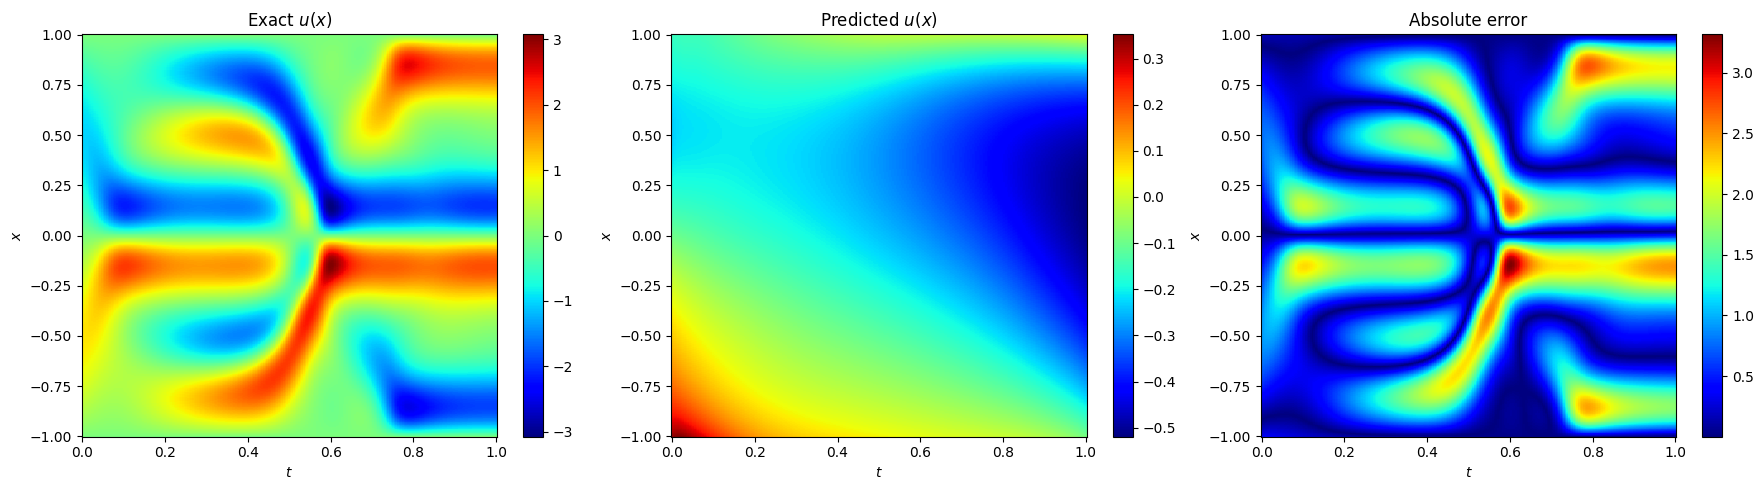

In [10]:
# Load the data and grid
data = scipy.io.loadmat('ks_simple.mat')
usol = data['usol']
t_star = data['t'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

u_pred = fwd(params, TT.flatten().reshape(-1,1), XX.flatten().reshape(-1,1))
u_pred = np.reshape(u_pred, (len(usol), len(usol[0])))
l2_error = np.linalg.norm(usol - u_pred) / np.linalg.norm(usol)
print('L2 error: {:.5e}'.format(l2_error))

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.show()